# Basics of Supervised Learning (mostly Classification)

Recall that the field of Supervised Learning is one in which you're trying to learn a function: $$f(x)=y$$ where you have some **labeled** data: that is, you have a dataset with both the inputs $x$ and the correct outputs $y$.  Here are some examples: 

1. Perhaps you're trying to predict the market rate of houses, and you have a collection of data on houses (such as address, town, number of beds/baths, square footage, acreage of yard, _etc._).  That's the _input_, $x$.  Suppose however you also have how much each house recently sold for.  That's the _output_ of your desired function, $y$.
2. Suppose you have a dataset of some health diagnostic tests for a person (such as their height, weight, blood pressure, blood sugar, family history of heart disease, _etc._), and you also know whether or not they've been diagnosed with diabetes.  If you'd like to train a model to predict diabetes whether someone has diabetes, then their diagnostics are your $x$ and whether they've been diagnosed is your $y$.

In these two cases, you're performing similar tasks: given some _labeled training data_, learn how to make a prediction on future data.  These are both examples of _Supervised Learning_.  The difference between them is:

1. Housing prices could be any real-valued number, realistically something in the tens of thousands to millions of dollars.  This process is called **Regression**.
2. Whether someone has a disease is deciding on a class: there is a set, finite (usually small) number of possible outputs.  This process is called **Classification**.

Let's take an example dataset.



In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.linear_model import LogisticRegression

In [2]:
def generate_data(seed, num_samples=10, noise=0.2):
    random.seed(seed)
    
    # Here, we make a function that chooses the output for a given input.  This is simply used to
    # generate some fake data.  In real life, you'd be given a labelled dataset!
    def generate_y(bp):
        noise_point = random.random() < noise
        if not noise_point:
            return 1 if bp > 145 else 0
        return 0 if bp > 145 else 1

    ids = list(range(num_samples))
    blood_pressures = [random.randrange(100, 165) for i in ids]
    has_disease = [generate_y(bp) for bp in blood_pressures]

    return pd.DataFrame({'blood_pressure': blood_pressures, 'has_disease': has_disease}, index=ids)

In [3]:
df = generate_data(14513)
df

,blood_pressure,has_disease
0,118,1
1,155,1
2,107,0
3,132,1
4,151,1
5,116,0
6,136,0
7,163,1
8,117,0
9,115,0


Okay, so we have some very simple data.  Let's graph it.

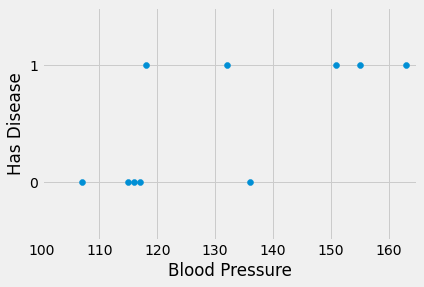

In [4]:
plt.scatter(df['blood_pressure'], df['has_disease'])
plt.xlabel('Blood Pressure')
plt.ylabel('Has Disease')
plt.yticks([0,1])
plt.ylim([-0.5, 1.5])
plt.xlim([100, 165])

plt.show()

Our data suggests that there is in fact some correlation with blood pressure and this mystery disease.  This is where machine learning comes in.  Suppose we are able to generate some function $f$, which produces a diagnosis given a blood pressure reading.  Here's an example function that we may be able to produce using a classification algorithm known as _Logistic Regression_.

In [5]:
DATA_MEAN = df['blood_pressure'].mean()
DATA_STD = df['blood_pressure'].std()

# Because this algorithm is high-powered and ready to be utilized in the real world, it's expecting
# more than one dimension of input.  Thus, we use this silly reshape command because our input, 
# blood pressure, is one-dimensional.  We also clean up the data to have mean 0 and a standard 
# deviation of 1 when it goes into the model.
def prepare_inputs(X):
    X = X - DATA_MEAN
    X = X / DATA_STD
    return X.reshape(-1, 1)

X = prepare_inputs(df['blood_pressure'].values)

model = LogisticRegression()
model.fit(X, df['has_disease'])

LogisticRegression()

So we have a model that has been trained on our data.  So what?  Let's figure out what it would predict for any given value in our range, and plot that.  This will give us a curve that we can interpret.

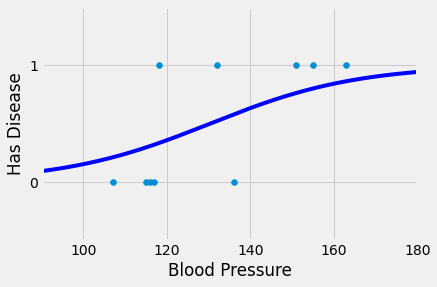

In [6]:
x_range = [90, 180]

bp_range = np.arange(x_range[0], x_range[1], 0.1)
outputs = model.predict_proba(prepare_inputs(bp_range))[:,1]

plt.scatter(df['blood_pressure'], df['has_disease'])
plt.xlabel('Blood Pressure')
plt.ylabel('Has Disease')
plt.yticks([0,1])
plt.ylim([-0.5, 1.5])
plt.xlim(x_range)
plt.plot(bp_range, outputs, color='blue')

plt.show()

So this _S_-curve in our graph is the output of our function.  Why isn't it $0$ or $1$?  We interpret it as the _probability of being $1$_, because it's a number between 0 and 1 that tends toward 0 near the cluster of 0's in the input data, and toward 1 near the cluster of 1's in the input data.  

So now the question is: what do we do with this?  Well, one thing you can do is to make a choice for a cutoff probability.  One obvious guess is 50\%: if I'm at least 50\% confident that the subject is a 1, I'll predict them to be a 1, otherwise they're a 0.  

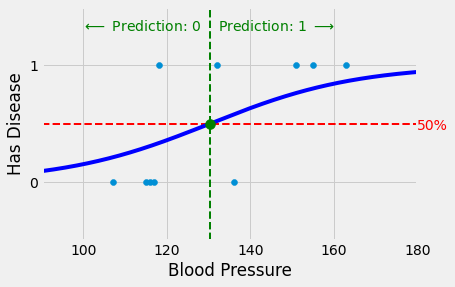

In [7]:
# We want to figure out at which blood pressure value my model predicts 50%.  This is something 
# particular to Logistic Regression, you don't need to understand why this line works.
cutoff_bp = -1 * model.intercept_[0] * DATA_STD / model.coef_[0] + DATA_MEAN

## Old:
plt.scatter(df['blood_pressure'], df['has_disease'])
plt.xlabel('Blood Pressure')
plt.ylabel('Has Disease')
plt.yticks([0,1])
plt.ylim([-0.5, 1.5])
plt.xlim(x_range)

## New:
plt.plot(x_range, [0.5, 0.5], 'r--', linewidth=2, zorder=1)
plt.text(x_range[1], 0.45, '50%', color='red')

plt.plot([cutoff_bp, cutoff_bp], [-0.5, 1.5], 'g--', linewidth=2, zorder=1)
plt.text(cutoff_bp + 2, 1.3, 'Prediction: 1 $\longrightarrow$', color='green')
plt.text(cutoff_bp - 2, 1.3, '$\longleftarrow$ Prediction: 0', color='green', ha='right')
plt.scatter([cutoff_bp], [0.5], s=100, zorder=2, color='green')

## Old:
plt.plot(bp_range, outputs, color='blue', zorder=1)

plt.show()

What you now see is that there are four quadrants of data points.  

### Correct
* In the top right corner are patients _with_ the disease that we successfully predicted _have_ the disease.  These are called **true positives**.
* In the bottom left corner are patients _without_ the disease that we successfully predicted _do not have_ the disease.  These are called **true negatives**.

### Incorrect
* In the top left corner are patients _with_ the disease that we incorrectly predicted _do not have_ the disease.  These are called **false negatives**. (_Think:_ "It's false that we predicted them to be negative") 
* In the bottom right corner are patients _without_ the disease that we incorrectly predicted _have_ the disease.  These are called **false positives**. (_Think:_ "It's false that we predicted them to be positive") 

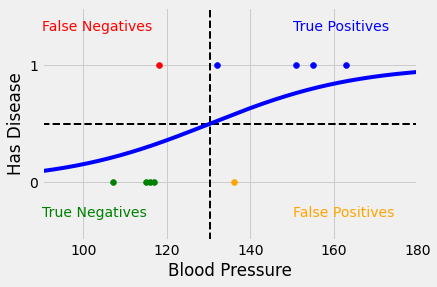

In [8]:
df['prediction'] = model.predict(prepare_inputs(df['blood_pressure'].values))

### For clarity's sake, let's split the data into its four categories, and then color them accordingly
true_positives = df[(df['has_disease'] == 1) & (df['prediction'] == 1)]
true_negatives = df[(df['has_disease'] == 0) & (df['prediction'] == 0)]
false_negatives = df[(df['has_disease'] == 1) & (df['prediction'] == 0)]
false_positives = df[(df['has_disease'] == 0) & (df['prediction'] == 1)]

datasets = [
    (true_positives, 'True Positives', 'blue', [cutoff_bp + 20, 1.3]),
    (true_negatives, 'True Negatives', 'green', [x_range[0], -0.3]),
    (false_negatives, 'False Negatives', 'red', [x_range[0], 1.3]),
    (false_positives, 'False Positives', 'orange', [cutoff_bp + 20, -0.3])
]

for dataset, title, color, loc in datasets:
    plt.scatter(dataset['blood_pressure'], dataset['has_disease'], c=color)
    plt.text(loc[0], loc[1], title, color=color)
    
## Old:
plt.xlabel('Blood Pressure')
plt.ylabel('Has Disease')
plt.yticks([0,1])
plt.ylim([-0.5, 1.5])
plt.xlim(x_range)

plt.plot(x_range, [0.5, 0.5], 'k--', linewidth=2)
plt.plot([cutoff_bp, cutoff_bp], [-0.5, 1.5], 'k--', linewidth=2)
plt.plot(bp_range, outputs, color='blue')

plt.show()

One final caveat: Whether something _in the training data_ was predicted correctly or incorrectly is not as important as you might expect.  The real goal here is to minimize incorrect predictions in data _you haven't seen before_, which is much harder, and is the focus of a great deal of tools.  Nonetheless, we could calculate our **training accuracy score**: 

In [ ]:
print('Training Accuracy:', df[df['has_disease'] == df['prediction']].shape[0] / df.shape[0])

Now, just because it's fun, let's turn all of the above code into a more interactive simulation.  Below I've bundled all the code up into a function with lots of parameters.  Try calling the function with various parameters to see what effect that has on your data and your model!

In [ ]:
def create_and_test_data_and_model(
    seed=14513, 
    num_samples=10, 
    noise=0.2,
    standardize_data=True,
):
    ### Generate data and calculate statistics
    df = generate_data(seed, num_samples=num_samples, noise=noise)
    x_range = [df['blood_pressure'].min() - 10, df['blood_pressure'].max() + 10]
    
    data_mean = df['blood_pressure'].mean() if standardize_data else 0
    data_std = df['blood_pressure'].std() if standardize_data else 1

    def prepare_inputs(X):
        X = X - data_mean
        X = X / data_std
        return X.reshape(-1, 1)

    X = prepare_inputs(df['blood_pressure'].values)

    ### Train model and make predictions
    model = LogisticRegression()
    model.fit(X, df['has_disease'])
    
    bp_range = np.arange(x_range[0], x_range[1], 0.1)
    outputs = model.predict_proba(prepare_inputs(bp_range))[:,1]
    
    cutoff_bp = -1 * model.intercept_[0] * data_std / model.coef_[0] + data_mean
    df['prediction'] = model.predict(prepare_inputs(df['blood_pressure'].values))

    ### Split the data into its four categories
    true_positives = df[(df['has_disease'] == 1) & (df['prediction'] == 1)]
    true_negatives = df[(df['has_disease'] == 0) & (df['prediction'] == 0)]
    false_negatives = df[(df['has_disease'] == 1) & (df['prediction'] == 0)]
    false_positives = df[(df['has_disease'] == 0) & (df['prediction'] == 1)]

    datasets = [
        (true_positives, 'True Positives', 'blue', [cutoff_bp + 20, 1.3]),
        (true_negatives, 'True Negatives', 'green', [x_range[0], -0.3]),
        (false_negatives, 'False Negatives', 'red', [x_range[0], 1.3]),
        (false_positives, 'False Positives', 'orange', [cutoff_bp + 20, -0.3])
    ]

    ### Create graph
    for dataset, title, color, loc in datasets:
        plt.scatter(dataset['blood_pressure'], dataset['has_disease'], c=color)
        plt.text(loc[0], loc[1], title, color=color)

    plt.xlabel('Blood Pressure')
    plt.ylabel('Has Disease')
    plt.yticks([0,1])
    plt.ylim([-0.5, 1.5])
    plt.xlim(x_range)

    plt.plot(x_range, [0.5, 0.5], 'k--', linewidth=2)
    plt.plot([cutoff_bp, cutoff_bp], [-0.5, 1.5], 'k--', linewidth=2)
    plt.plot(bp_range, outputs, color='blue')

    print('Training Accuracy:', df[df['has_disease'] == df['prediction']].shape[0] / df.shape[0])
    plt.show()

In [ ]:
create_and_test_data_and_model(
    seed=None, 
    num_samples=100, 
    noise=0.15,
    standardize_data=True,
)